In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch 
import numpy as np

from nltk.tokenize import sent_tokenize 

import pandas as pd
from pathlib import Path 
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from transformers import AdamW
from tqdm import tqdm

from transformers import AutoTokenizer, BertConfig, BertModel, BertTokenizer
from transformers import DistilBertTokenizer, DistilBertModel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ECE1786 Project/Dataset/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1fJllm6_aqmmawo8B6hq9rhewEDIBmSpR/ECE1786 Project/Dataset


In [ ]:
df = pd.read_csv('dataset_all_genres.csv')
df['primary_genre'].value_counts()

Rock       25177
Pop        13759
Indie      12998
Hip Hop     8412
Country     7377
R&B         5309
Blues       2038
EDM         1758
Name: primary_genre, dtype: int64

In [ ]:
df_sampled = df.groupby('primary_genre').sample(n=1750, random_state=200)

In [ ]:
#instantiate the bert model and tokenizer
# model_name = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# tokenizer.padding_side = "right"
# # tokenizer.pad_token = tokenizer.eos_token
# tokenizer.pad_token = "[PAD]"
# bert = BertModel.from_pretrained(model_name)

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"
tokenizer.pad_token = "[PAD]"
bert = DistilBertModel.from_pretrained(model_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# freeze all the parameters
# for param in bert.parameters():
#     param.requires_grad = False

In [ ]:
class BERTClassifier(nn.Module):
  def __init__(self, embedding_size, num_classes, max_seq_len, model_name):
    super(BERTClassifier,self).__init__()
    self.bert = bert
    self.classifier_head = nn.Sequential(
                            nn.Linear(embedding_size*max_seq_len, 768),
                            nn.ReLU(),
                            nn.Dropout(0.1),
                            nn.Linear(768, num_classes)
                          )

  def forward(self, input_id, mask):
    bert_out = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)[0]
    batch_size = bert_out.shape[0]
    linear_output = self.classifier_head(bert_out.view(batch_size,-1))
    return linear_output

In [ ]:
"""
Prepare the dataset to finetune a transformer model

Arguments:
            ds_choice: str. "small" or "large". (i.e. selects which of the two datasets)
            split: str. "train" or "test".
            truncation: int. If -1: no truncation on sentences. Otherwise: truncate to this specific length.
""" 
genre_labels = {'Blues': 0, 'Country': 1, 'EDM': 2, 'Hip Hop': 3, 'Indie': 4, 'Pop': 5, 'R&B': 6, 'Rock': 7}
#genre_labels = {'Country': 0, 'Hip Hop': 1, 'Indie': 2, 'Pop': 3, 'R&B': 4, 'Rock': 5}
class SongGenreClassificationDataset(Dataset):
    
    def __init__(self, texts, genres, max_length=256):
        if 'secondary_genre' in genres.columns:
          self.primary_labels = [genre_labels[genre] for genre in genres['primary_genre']]
          self.secondary_labels = [genre_labels[genre] if pd.notna(genre) else -1 for genre in genres['secondary_genre']]
        else:
          self.primary_labels = [genre_labels[genre] for genre in genres]
          self.secondary_labels = [-1 for genre in genres]
          # Tokenize
        self.tokenizer = tokenizer
        self.lyrics = []

        for text in texts:
          text = text.replace("\n\n", "$$^^$$").replace("\n", " ").replace("$$^^$$", "\n")
          self.lyrics.append(self.tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt"))      

    def __len__(self):
        return len(self.primary_labels)

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for 
        how the x and y are going to be used.
        """
        x = self.lyrics[idx]
        if len(self.secondary_labels) > 0:
          primary = self.primary_labels[idx]
          secondary = self.secondary_labels[idx]
          if secondary == -1:
            secondary = primary
          y = (primary, secondary)
        else:
          y = self.primary_labels[idx]
        return (x, y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_sampled['lyrics'], df_sampled[['primary_genre', 'secondary_genre']], test_size=0.3, random_state = 200)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state = 200)

In [ ]:
def train(model, train_data, train_labels, val_data, val_labels, learning_rate, epochs, batch_size=2, max_seq_length=256):
    train, val = SongGenreClassificationDataset(train_data, train_labels,
                                                max_length=max_seq_length), SongGenreClassificationDataset(val_data, val_labels, max_length=max_seq_length)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

    # print(f"train dataloader: {len(train_dataloader)}")
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    print(f"training on {device}")
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    running_train_loss = []
    running_train_acc = []
    running_val_loss = []
    running_val_acc = []
    
    if use_cuda:
        print('using cuda')
        model = model.cuda()
        loss_fn = loss_fn.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        print('starting')
        for i, (train_input, train_labels) in enumerate(tqdm(train_dataloader)):
            # train_labels = train_labels.to(device)
            if len(train_labels) > 1:
              train_label_primary = train_labels[0].to(device)
              train_label_secondary = train_labels[1].to(device)
            else:
              print('not val_labels')
              train_label_primary = train_labels.to(device)
            # train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)

            # batch_loss = loss_fn(output, train_label)
            batch_loss_primary = loss_fn(output, train_label_primary)
            

            if len(train_labels) > 1:
              batch_loss_secondary = loss_fn(output, train_label_secondary)
              

            total_loss_train += (max(batch_loss_primary.item(), batch_loss_secondary.item()))

            prediction_matches_primary = output.argmax(dim=1) == train_label_primary 
            prediction_matches_secondary = output.argmax(dim=1) == train_label_secondary 

            acc = torch.maximum(prediction_matches_primary, prediction_matches_secondary).sum().item()
            total_acc_train += acc

            if batch_loss_primary.item() < batch_loss_secondary.item():
              batch_loss_secondary.backward()
            else:
              batch_loss_primary.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_labels in val_dataloader:

              if len(val_labels) > 1:
                val_label_primary = val_labels[0].to(device)
                val_label_secondary = val_labels[1].to(device)
              else:
                val_label_primary = val_labels.to(device)
                val_label = val_label.to(device)

              mask = val_input['attention_mask'].to(device)
              input_id = val_input['input_ids'].squeeze(1).to(device)
              
              output = model(input_id, mask)
              
              batch_loss_primary = loss_fn(output, val_label_primary)
            
              if len(val_labels) > 1:
                batch_loss_secondary = loss_fn(output, val_label_secondary)

              total_loss_val += (max(batch_loss_primary.item(), batch_loss_secondary.item()))
              # total_loss_val += batch_loss.item()

              prediction_matches_primary = output.argmax(dim=1) == val_label_primary 
              prediction_matches_secondary = output.argmax(dim=1) == val_label_secondary 
              
              acc = torch.maximum(prediction_matches_primary, prediction_matches_secondary).sum().item()
              # acc = (output.argmax(dim=1)==val_label).sum().item()
              total_acc_val += acc

            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

            running_train_loss.append(total_loss_train/len(train_data))
            running_train_acc.append(total_acc_train / len(train_data))
            running_val_loss.append(total_loss_val / len(val_data))
            running_val_acc.append(total_acc_val / len(val_data))
            
    return model, running_train_loss, running_train_acc, running_val_loss, running_val_acc

In [ ]:
EPOCHS = 4
model = BERTClassifier(embedding_size=768, num_classes=8, max_seq_len=256, model_name=model_name)
LR = 5e-6

# train_data, train_labels, val_data, val_labels
model, running_train_loss, running_train_acc, running_val_loss, running_val_acc = train(model, x_train, y_train, x_val, y_val, LR, EPOCHS)

training on cuda
using cuda


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


starting


100%|██████████| 4900/4900 [10:14<00:00,  7.97it/s]


Epochs: 1 | Train Loss:  0.778             | Train Accuracy:  0.520             | Val Loss:  0.727             | Val Accuracy:  0.573
starting


100%|██████████| 4900/4900 [10:15<00:00,  7.96it/s]


Epochs: 2 | Train Loss:  0.472             | Train Accuracy:  0.812             | Val Loss:  0.762             | Val Accuracy:  0.585
starting


100%|██████████| 4900/4900 [10:15<00:00,  7.96it/s]


Epochs: 3 | Train Loss:  0.342             | Train Accuracy:  0.975             | Val Loss:  0.752             | Val Accuracy:  0.604
starting


100%|██████████| 4900/4900 [10:17<00:00,  7.94it/s]


Epochs: 4 | Train Loss:  0.258             | Train Accuracy:  0.996             | Val Loss:  0.769             | Val Accuracy:  0.600


In [ ]:
torch.save(model.state_dict(), "distil_bert_classifier.pt")

In [ ]:
def evaluate_multiple_correct(model, test_data, test_labels):

    test = SongGenreClassificationDataset(test_data, test_labels)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_labels in test_dataloader:

            if len(test_labels) > 1:
                test_label_primary = test_labels[0].to(device)
                test_label_secondary = test_labels[1].to(device)
                
            else:
                test_label_primary = test_labels.to(device)

            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            prediction_matches_primary = output.argmax(dim=1) == test_label_primary 
            prediction_matches_secondary = output.argmax(dim=1) == test_label_secondary 
              
            acc = torch.maximum(prediction_matches_primary, prediction_matches_secondary).sum().item()
            total_acc_test += acc
            
            # add original labels
            test_label_primary = test_label_primary.cpu().numpy().flatten().tolist()
            test_label_secondary = test_label_secondary.cpu().numpy().flatten().tolist()
            output_preds = output.argmax(dim=1).cpu().numpy().flatten().tolist()

            for i in range(len(test_label_primary)):
                if test_label_primary[i] == output_preds[i]:
                    true_labels.append(test_label_primary[i])
                elif test_label_secondary[i] == output_preds[i]:
                    true_labels.append(test_label_secondary[i])
                else:
                    true_labels.append(test_label_primary[i])

            # true_labels += test_label_secondary.cpu().numpy().flatten().tolist()
            # get predictions to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

Test Accuracy:  0.602


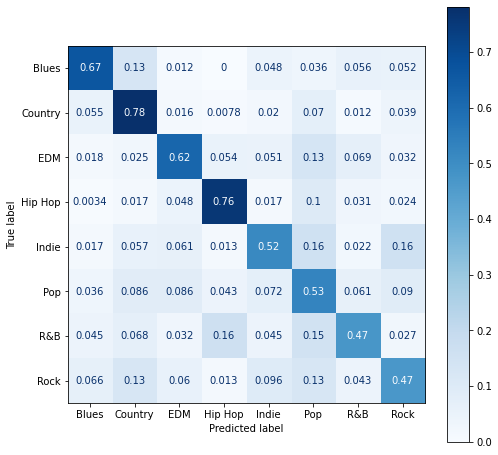

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels, pred_labels = evaluate_multiple_correct(model, x_val, y_val)
fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(genre_labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(genre_labels.keys()))
disp.plot(ax=ax, cmap='Blues')